In [1]:
#               __  ___  _      __                ___              _     ___                    _      ___     _            _   _             
#              /__\/   \/_\    / _| ___  _ __    / __\__ _ _ __ __| |   / __\ __ __ _ _   _  __| |    /   \___| |_ ___  ___| |_(_) ___  _ __  
#             /_\ / /\ //_\\  | |_ / _ \| '__|  / /  / _` | '__/ _` |  / _\| '__/ _` | | | |/ _` |   / /\ / _ \ __/ _ \/ __| __| |/ _ \| '_ \ 
#            //__/ /_//  _  \ |  _| (_) | |    / /__| (_| | | | (_| | / /  | | | (_| | |_| | (_| |  / /_//  __/ ||  __/ (__| |_| | (_) | | | |
#            \__/___,'\_/ \_/ |_|  \___/|_|    \____/\__,_|_|  \__,_| \/   |_|  \__,_|\__,_|\__,_| /___,' \___|\__\___|\___|\__|_|\___/|_| |_|

Credit Card Fraud Detection is a classic class-imbalance problem where the number of fraud transactions is much lesser than the number of legitimate transaction for any bank. Most of the approaches involve building model on such imbalanced data, and thus fails to produce results on real-time new data because of overfitting on training data and a bias towards the majoritarian class of legitimate transactions. Thus, we can see this as an anomaly detection problem.

1. What time does the Credit Card Frauds usually take place?
2. What are the general trends of amounts for Credit Card Fraud Transactions?
3. How do we balance the data to not let the model overfit on legitimate transactions?
4. Are the links an important weight to determine the output?

In [2]:
# Libraries are imported.
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from plotly.subplots import make_subplots
from nltk.tokenize import RegexpTokenizer
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from datetime import datetime
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import csv

In [3]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> Data pre-processing <-------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# Reading the file.
df_train = pd.read_csv('/Users/alejandro/Desktop/Life/Credit-Card-Fraud-Detection/Datasets/training.csv', delimiter=',', encoding='utf-8', index_col=[0])

In [5]:
# The first 10 rows were printed.
print(df_train.head(10))

        trans_date_trans_time               cc_num  \
812459    2019-12-07 13:42:16      341546199006537   
83440     2019-02-18 20:09:17      213156747557083   
1087534   2020-03-28 10:55:40     2297447006766555   
551435    2019-08-24 06:48:35  4560395181594436016   
1175617   2020-05-05 15:00:05     6011381817520024   
669299    2019-10-12 17:23:44      213163860545705   
1230631   2020-05-28 21:37:08       30273037698427   
184355    2019-04-06 11:31:08     3519232971341141   
691670    2019-10-21 20:00:34     4149238353975790   
1206001   2020-05-19 02:06:28     3543299015720986   

                                   merchant        category     amt    first  \
812459                     fraud_Bednar PLC       kids_pets  102.52     Mark   
83440    fraud_Turcotte, Batz and Buckridge  health_fitness   14.77     Adam   
1087534             fraud_Bartoletti-Wunsch   gas_transport   63.02    Laura   
551435        fraud_Lockman, West and Runte     grocery_pos  237.50   Angela   
11756

In [6]:
# The columns were printed.
print(df_train.columns)

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'Link'],
      dtype='object')


In [7]:
# First it is necessary to drop all the duplicate values. Although, the shell script is in charge of that.
df_train = df_train.copy()
df_train.drop_duplicates(inplace = True)
print("Duplicated values dropped successfully")

Duplicated values dropped successfully


In [8]:
# Some columns get renamed.
df_train.rename(columns = {'trans_date_trans_time':'transaction_time',
                         'cc_num':'credit_card_number',
                         'amt':'amount(usd)',
                         'trans_num':'transaction_id'},
                inplace = True)

In [9]:
# The datetime columns were converted.
# transaction_time and dob should be in pd.datetime format and we also convert unix_time to exact timestamp
df_train['transaction_time'] = pd.to_datetime(df_train['transaction_time'], infer_datetime_format = True)
df_train['dob'] = pd.to_datetime(df_train['dob'], infer_datetime_format = True)

In [10]:
# A function was applied utcfromtimestamp and was dropped column unix_time
df_train['time'] = df_train['unix_time'].apply(datetime.utcfromtimestamp)
df_train.drop('unix_time', axis=1)
# A column with hour of day was added.
df_train['hour_of_day'] = df_train.time.dt.hour

In [11]:
# Credit card number should be integers not dtypes.
# Change dtypes
df_train.credit_card_number = df_train.credit_card_number.astype('category')
df_train.is_fraud = df_train.is_fraud.astype('category')
df_train.hour_of_day = df_train.hour_of_day.astype('category')
# Check
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481915 entries, 812459 to 599200
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   transaction_time    1481915 non-null  datetime64[ns]
 1   credit_card_number  1481915 non-null  category      
 2   merchant            1481915 non-null  object        
 3   category            1481915 non-null  object        
 4   amount(usd)         1481915 non-null  float64       
 5   first               1481915 non-null  object        
 6   last                1481915 non-null  object        
 7   gender              1481915 non-null  object        
 8   street              1481915 non-null  object        
 9   city                1481915 non-null  object        
 10  state               1481915 non-null  object        
 11  zip                 1481915 non-null  int64         
 12  lat                 1481915 non-null  float64       
 13  long    

In [12]:
df_train[['time','hour_of_day']]

,time,hour_of_day
812459,2012-12-07 13:42:16,13
83440,2012-02-18 20:09:17,20
1087534,2013-03-28 10:55:40,10
551435,2012-08-24 06:48:35,6
1175617,2013-05-05 15:00:05,15
...,...,...
20519,2013-06-28 15:16:10,15
1156371,2013-04-27 12:34:45,12
143576,2013-08-10 13:56:14,13
306565,2012-05-28 17:16:05,17


In [13]:
# Change dtypes.
df_train.credit_card_number = df_train.credit_card_number.astype('category')
df_train.is_fraud = df_train.is_fraud.astype('category')
df_train.hour_of_day = df_train.hour_of_day.astype('category')
# Check.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481915 entries, 812459 to 599200
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   transaction_time    1481915 non-null  datetime64[ns]
 1   credit_card_number  1481915 non-null  category      
 2   merchant            1481915 non-null  object        
 3   category            1481915 non-null  object        
 4   amount(usd)         1481915 non-null  float64       
 5   first               1481915 non-null  object        
 6   last                1481915 non-null  object        
 7   gender              1481915 non-null  object        
 8   street              1481915 non-null  object        
 9   city                1481915 non-null  object        
 10  state               1481915 non-null  object        
 11  zip                 1481915 non-null  int64         
 12  lat                 1481915 non-null  float64       
 13  long    

In [14]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------> End or data preprocessing <-------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------> Data cleaning <----------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
# The first 10 rows were printed.
df_train.isnull().sum()

transaction_time      0
credit_card_number    0
merchant              0
category              0
amount(usd)           0
first                 0
last                  0
gender                0
street                0
city                  0
state                 0
zip                   0
lat                   0
long                  0
city_pop              0
job                   0
dob                   0
transaction_id        0
unix_time             0
merch_lat             0
merch_long            0
is_fraud              0
Link                  0
time                  0
hour_of_day           0
dtype: int64

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1481915 entries, 812459 to 599200
Data columns (total 25 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   transaction_time    1481915 non-null  datetime64[ns]
 1   credit_card_number  1481915 non-null  category      
 2   merchant            1481915 non-null  object        
 3   category            1481915 non-null  object        
 4   amount(usd)         1481915 non-null  float64       
 5   first               1481915 non-null  object        
 6   last                1481915 non-null  object        
 7   gender              1481915 non-null  object        
 8   street              1481915 non-null  object        
 9   city                1481915 non-null  object        
 10  state               1481915 non-null  object        
 11  zip                 1481915 non-null  int64         
 12  lat                 1481915 non-null  float64       
 13  long    

In [18]:
# Extracting the link and making copies. 
X = df_train[['Link']].copy()
y = df_train.is_fraud.copy()

In [19]:
# Initialize the tokenizer, steamer and Vectorizer.
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
stemmer = SnowballStemmer("english")
cv = CountVectorizer()

In [41]:
#  Prepare the data for the model.
def prepare_data(X) :
    # Tokenize the text.
    X['text_tokenized'] = X.URL.map(lambda t: tokenizer.tokenize(t))
    # Stem the text.
    X['text_stemmed'] = X.text_tokenized.map(lambda t: [stemmer.stem(word) for word in t])
    # Join the text.
    X['text_sent'] = X.text_stemmed.map(lambda t: ' '.join(t))
    # Vectorize the text.
    features = cv.fit_transform(X.text_sent)
    # Return the features and the target.
    return X, features

In [20]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------> Unbalanced data check <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
# The  number of classes got counted, in this case, fraudulent or not.
df_train['is_fraud'].value_counts()

0    1474161
1       7754
Name: is_fraud, dtype: int64

In [22]:
# Labeling the data in genuine and fraudulent transactions, this way it is easier to observe that the data is unbalanced.
labels=["Genuine", "Fraud"]
fraud_or_not = df_train['is_fraud'].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]
# Plotting the values.
fig = px.pie(values = df_train['is_fraud'].value_counts(), names = labels , width = 700, height = 400, color_discrete_sequence = ["skyblue", "black"]
             ,title = "Fraud vs Genuine transactions")
fig.show()

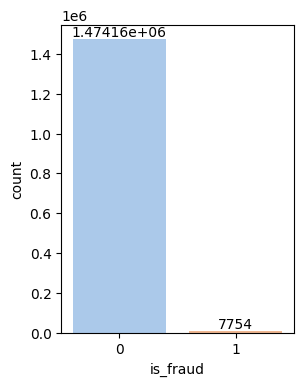

In [23]:
# Unbalance data represented with bars.
plt.figure(figsize = (3,4))
ax = sns.countplot(x = 'is_fraud', data = df_train, palette = "pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [24]:
# Percentage of data.
print('Genuine transactions:', round(df_train['is_fraud'].value_counts()[0]/len(df_train) * 100,2), '% of the dataset')
print('Fraudulent transactions:', round(df_train['is_fraud'].value_counts()[1]/len(df_train) * 100,2), '% of the dataset')

Genuine transactions: 99.48 % of the dataset
Fraudulent transactions: 0.52 % of the dataset


In [25]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------> Unbalanced data check was finished <--------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------------------> Exploratory Data Analysis <------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# A quick statistical summary of the columns was made.
np.round(df_train.describe(), 2)

,amount(usd),zip,lat,long,city_pop,unix_time,merch_lat,merch_long
count,1481915.00,1481915.00,1481915.00,1481915.00,1481915.00,1.481915e+06,1481915.00,1481915.00
mean,70.00,48810.92,38.54,-90.23,88464.35,1.358672e+09,38.54,-90.23
std,156.88,26882.64,5.07,13.75,301060.17,1.819529e+07,5.11,13.76
min,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67
25%,9.65,26237.00,34.67,-96.80,743.00,1.343012e+09,34.74,-96.90
50%,47.44,48174.00,39.35,-87.48,2443.00,1.357081e+09,39.37,-87.44
75%,83.09,72011.00,41.94,-80.16,20328.00,1.374578e+09,41.96,-80.24
max,27390.12,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95


In [28]:
# Quick Summarize using pandas_profiling was realized.
groups = [pd.Grouper(key="transaction_time", freq="1W"), "is_fraud"]
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

In [29]:
# -------------------------------------------------------------------------------------------------------------------------------------------------
# 
def add_traces(df, x, y,hue, mode, cmap, showlegend=None):
    # Name_map/HUE is the column name of the categorical variable.
    name_map = {1:"Yes", 0:"No"}
    # Create a list of traces.
    traces = []
    # Loop through the unique values of the categorical variable.
    for flag in df[hue].unique():
        # Append a trace to the list.
        traces.append(
            # Scatter plot.
            go.Scatter(
                x=df[df[hue]==flag][x],
                y=df[df[hue]==flag][y],
                mode=mode,
                # Color of the trace.
                marker=dict(color=cmap[flag]),
                showlegend=showlegend,
                name=name_map[flag]
            )
        )
    return traces
# -------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Create figure with secondary y-axis.
fig = make_subplots(rows=2, cols=2,
                    specs=[
                        [{}, {}],
                        [{"colspan":2}, None]
                    ],
                    subplot_titles=("Amount(usd) over time", "Number of transactions overtime",
                                    "Number of transaction by amount(usd)")
                   )

# Add traces.
ntraces = add_traces(df=df_,x='transaction_time',y='amount(usd)',hue='is_fraud',mode='lines',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])


# Add traces.
for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=1
    )
    
# Add traces.
ntraces = add_traces(df=df_,x='transaction_time',y='transaction_id',hue='is_fraud',mode='lines',
                    showlegend=False, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=1,col=2
    )

# Add traces.
ntraces = add_traces(df=df_,x='transaction_id',y='amount(usd)',hue='is_fraud',mode='markers',
                    showlegend=True, cmap=['#61E50F','#D93C1D'])
for trace in ntraces:
    fig.add_trace(
        trace,
        row=2,col=1
    )

# Add figure title.
fig.update_layout(height=780,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa',
                  title='Overview'
                 )

fig.show()

In [31]:
# The category of the fraudulent transactions was plotted.
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),
                           'is_fraud','category']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

# The category of the fraudulent transactions was plotted.
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='category',
        facet_col_wrap=3,
        facet_col_spacing=.04,
        color_discrete_map={0:'#61E50F', 1:'#D93C1D'}
)

# The category of the fraudulent transactions was plotted.
fig.update_layout(height=1400,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))
fig.show();

In [32]:
# The category of the fraudulent transactions was plotted.
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1M"),
                           'is_fraud','category']).agg({"amount(usd)":'sum',"transaction_id":"count"}).reset_index()

fig = px.area(
    df_[df_.is_fraud==1],
    x='transaction_time',
    y='amount(usd)',
    color='category',
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(height=600,
                  width=960,
                  legend=dict(title='Type of business'),
                  plot_bgcolor='#fafafa'
                 )
fig.show();

In [33]:
# Specified list of 10 business with the highest number of transactions.
top12_merchants = df_train.merchant.value_counts()[:12]
df_ = df_train.groupby(by=[pd.Grouper(key="transaction_time", freq="1W"),'is_fraud',
                           'merchant']).agg({"amount(usd)":'mean',"transaction_id":"count"}).reset_index()

# The category of the fraudulent transactions was plotted.
df_ = df_[df_.merchant.isin(top12_merchants.index)]

# The category of the fraudulent transactions was plotted.
fig = px.scatter(df_,
        x='transaction_time',
        y='amount(usd)',
        color='is_fraud',
        facet_col ='merchant',
        facet_col_wrap=3,
        facet_col_spacing=.06,
        category_orders={'merchant': top12_merchants.index}, # order the subplots
        color_discrete_map={1:'#61E50F', 0:'#D93C1D'}
)

# The category of the fraudulent transactions was plotted.
fig.update_layout(height=1200,
                  width=960,
                  title='Top 12 merchants with highest number of transactions per week',
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))
fig.show();

In [34]:
# Top 10 jobs had most fraud transactions.
groups = ['is_fraud','job']
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_ = df_[df_.is_fraud==1].sort_values(by='transaction_id',
                                       ascending=False).drop_duplicates('job', keep='first').iloc[:10, :]
df_

,is_fraud,job,amount(usd),transaction_id
806,1,Naval architect,615.893462,52
880,1,Quantity surveyor,621.307600,50
784,1,Materials engineer,544.603404,47
918,1,Senior tax professional/tax inspector,562.001111,45
539,1,Audiological scientist,653.637111,45
977,1,Trading standards officer,497.333864,44
939,1,"Surveyor, land/geomatics",503.585814,43
691,1,Film/video editor,533.244884,43
589,1,Colour technologist,493.670732,41
599,1,Comptroller,532.219250,40


In [35]:
# The professions with the highest amount of fraudulent transactions were plotted.
fig = px.bar(df_,
             y='job', x='transaction_id',
             color='amount(usd)',
             color_continuous_scale=px.colors.sequential.Magma,
             labels={'job':'Job title', 
                     'transaction_id': 'Number of fraud transactions'},
             category_orders = {"job": df_.job.values},
             width=960,
             height=600)

# The colorbar was added to the plot.
fig.update_layout(
    title=dict(
        text='Amount in USD among top 10 jobs with the most fraud transactions'
    ),
    plot_bgcolor='#fafafa'
)

# The colorbar was added to the plot.
fig.update_coloraxes(
    colorbar=dict(
        title='Amount(usd) of transactions',
        orientation='h',
        x=1
    ),
    reversescale=True
)

# The plot was shown.
fig.show()

In [36]:
# Plotting the credit card numbers and card holders with the highest amount of fraudulent transactions.
groups = ['credit_card_number']
df_ = df_train.groupby(by=groups).agg({"amount(usd)":'mean',"transaction_id":"count"}).fillna(0).reset_index()
df_.sort_values('transaction_id', ascending=False, inplace=True)
df_ = df_.head(10)

In [37]:
# Plotting the credit card numbers and card holders with the highest amount of fraudulent transactions.
df_ = df_train[df_train.is_fraud==1].groupby(by='hour_of_day').agg({'transaction_id':'count'}).reset_index()

# Plotting the number of fraudulent transactions by hours of day.
fig = px.bar(data_frame=df_,
       x='hour_of_day',
       y='transaction_id',
       labels={'transaction_id':'Number of transaction'})

# Setting the title and background color.
fig.update_layout(
    title=dict(
        text='Number of FRAUD transactions by hours of day'
    ),
    plot_bgcolor='#fafafa'
)

# Plotting the number of fraudulent transactions by hours of day.
fig.update_xaxes(type='category')

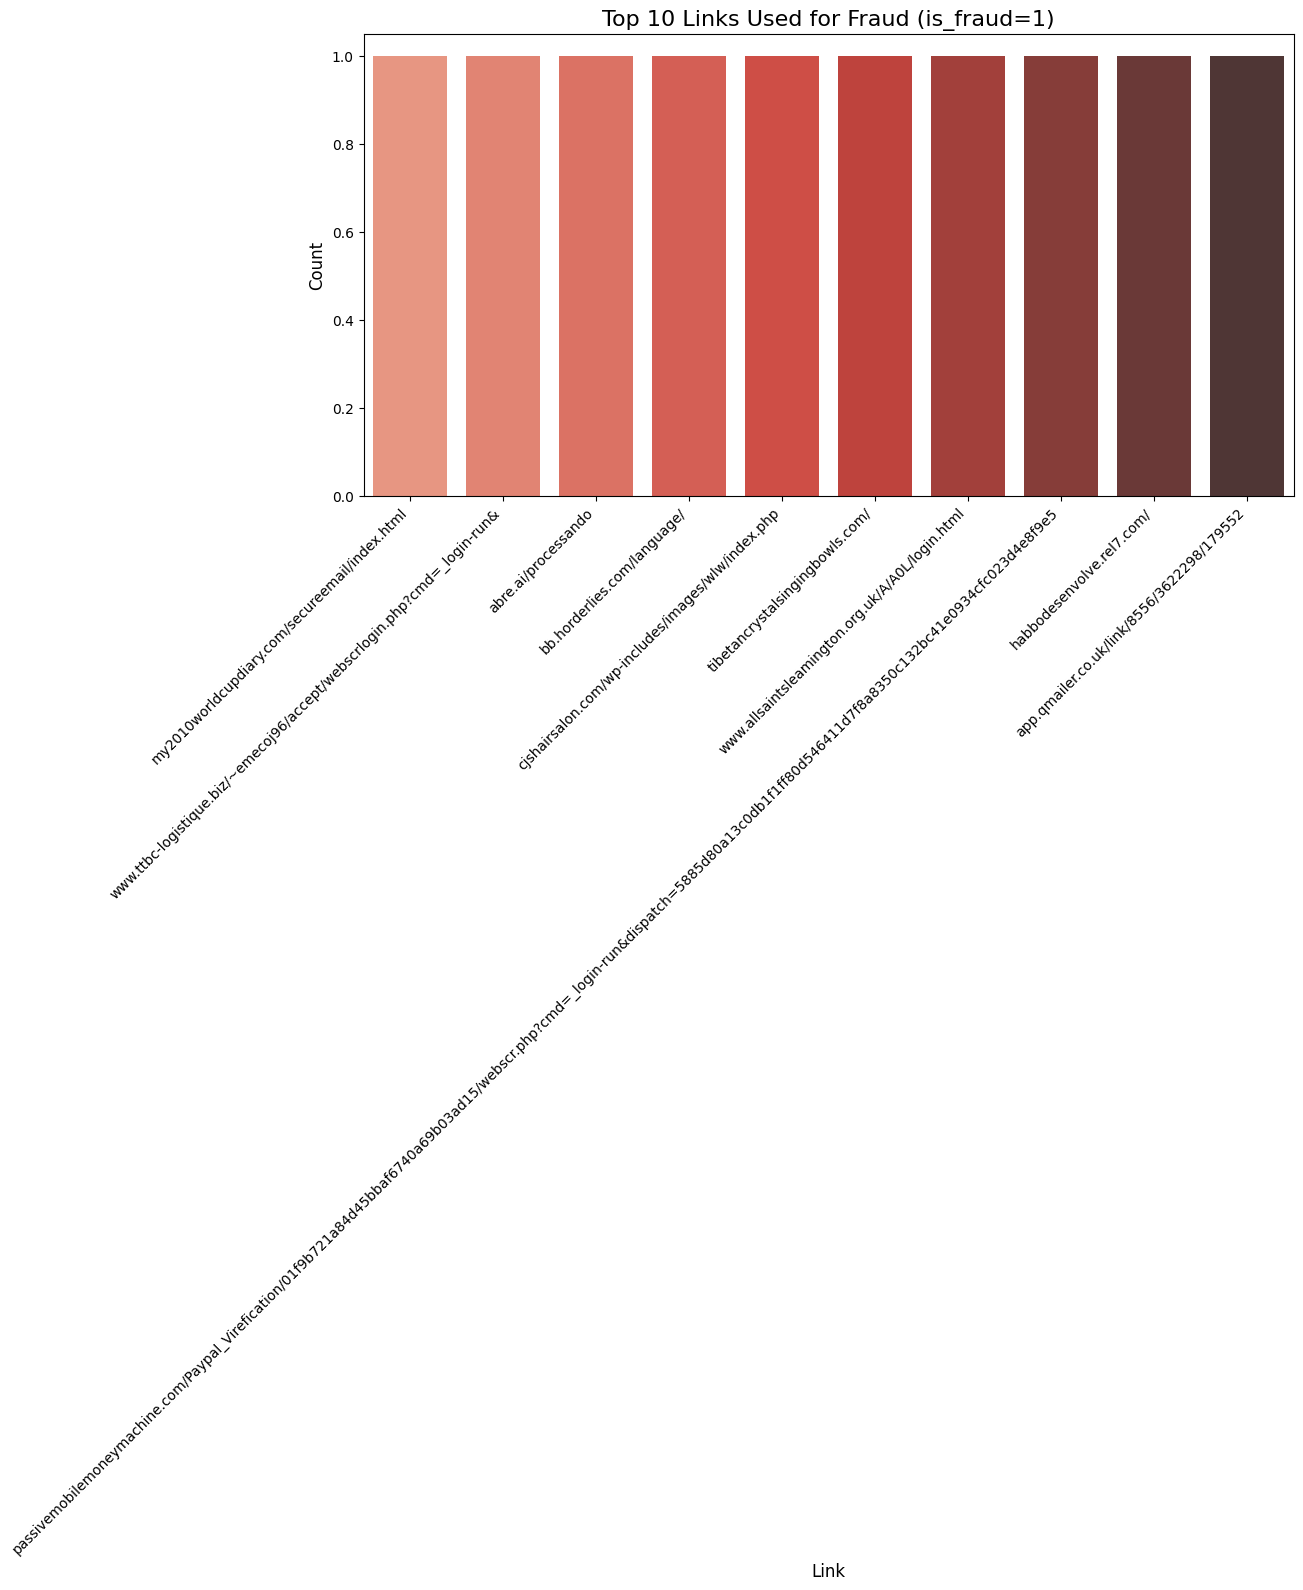

In [38]:
# Create a new DataFrame that contains the counts of each link.
top_links_fraud = df_train[df_train["is_fraud"]==1]["Link"].value_counts().head(10)

# Create a bar plot of the top 10 links used for fraud.
plt.figure(figsize=(12,6))
sns.barplot(x=top_links_fraud.index, y=top_links_fraud.values, palette="Reds_d")
plt.title("Top 10 Links Used for Fraud (is_fraud=1)", fontsize=16)
plt.xlabel("Link", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

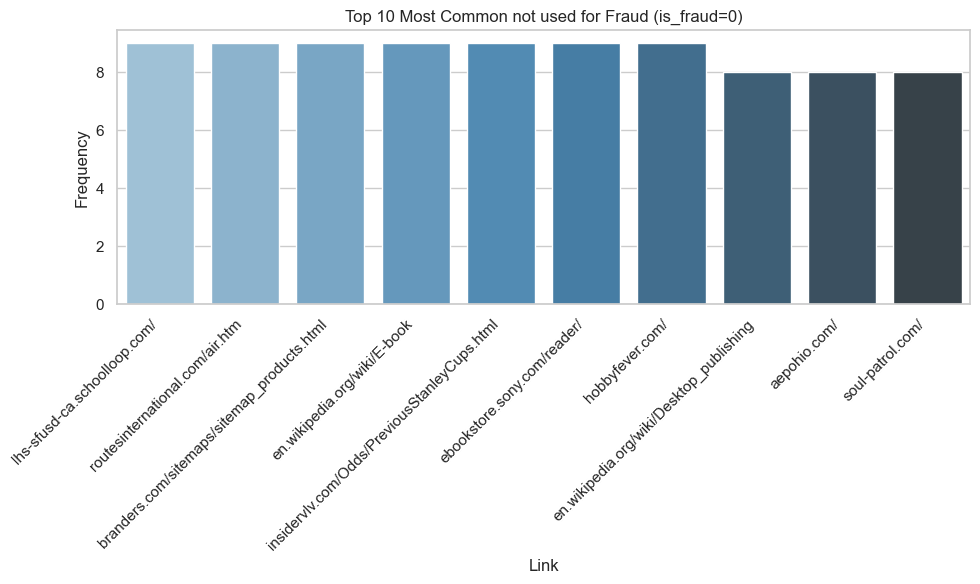

In [39]:
# Filter out the fraudulent links
df_fraud = df_train[df_train['is_fraud'] == 1]

# Count the occurrences of each link
link_counts = df_train[df_train['is_fraud'] == 0]['Link'].value_counts()

# Select the most common links
top_links = link_counts.nlargest(10)

# Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_links.index, y=top_links.values, palette="Blues_d")
plt.title("Top 10 Most Common not used for Fraud (is_fraud=0)")
plt.xlabel("Link")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/1p/27jszvps12x14r9hnwf07w240000gn/T/ipykernel_40768/809039022.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



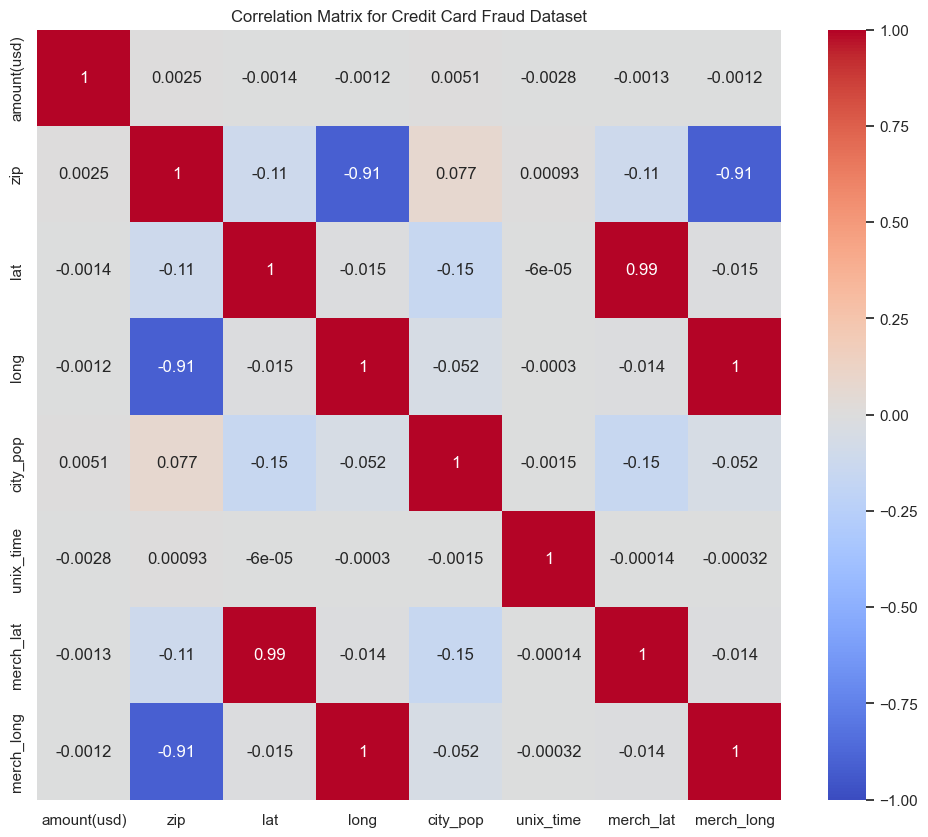

In [40]:
# Calculate the correlation matrix
corr_matrix = df_train.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Credit Card Fraud Dataset')
plt.show()